# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

sat_survey_corr = correlations
sat_survey_corr = sat_survey_corr.loc[survey_fields]

sat_survey_corr.plot.bar()

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

High correlations with SAT Scores:
- `saf_t_11`: how teachers percieve safety at school
- `saf_s_11`: how students percieve safety at school


## Student Safety Perception:

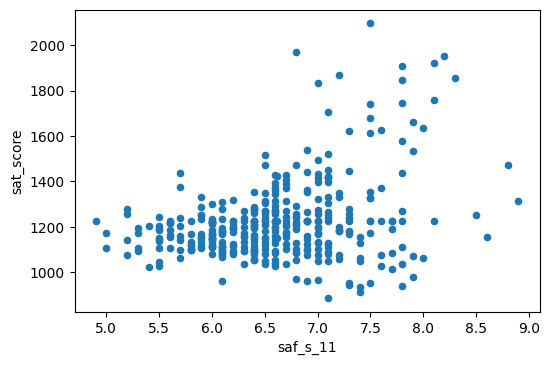

In [11]:
combined.plot.scatter('saf_s_11', 'sat_score')

Moderately positive correlation between student perception of safety and SAT scores.

In [ ]:
# average safety scores for each borough:
boroughs = combined.groupby('boro').agg('mean')
boroughs_saf = boroughs['saf_s_11']
boroughs_saf.plot.barh(title = 'Student Safety Perception Score by Sector')

## Racial DIfferences 

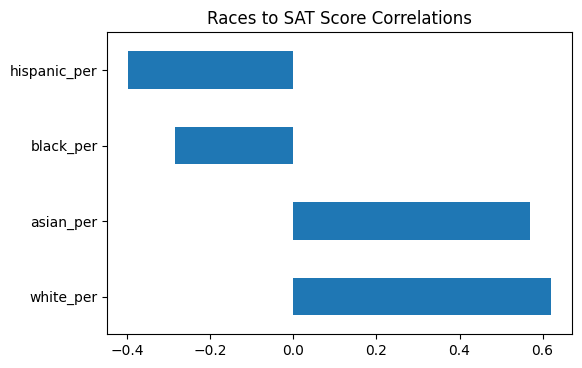

In [14]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations_race = correlations.loc[races]

correlations_race.plot.barh(title = 'Races to SAT Score Correlations')

Both White and Asian Students have strong posititve correlations.
Black and Hispanic Students have negative correlations.

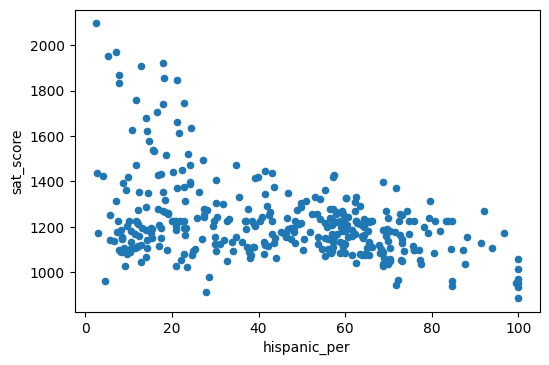

In [15]:
# explore low sat scoring schools with a highpercentage of hispanics.
# scatter hispanic_per vs sat_score

combined.plot.scatter('hispanic_per', 'sat_score')


The greater the hispanic percentage the lower the average sat score is.

In [19]:
hispanic_schools = combined[combined['hispanic_per'] > 95]
hispanic_schools['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools all seem to have either international, multicultural, or expeditionary learning environments.


In [21]:
# hispanic percentages less than 10%

hispanic_schools = combined[combined['hispanic_per'] < 10]
hispanic_schools['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

These schools all seem to be prep schools or highly prestigous private schools.

## Gender Differences

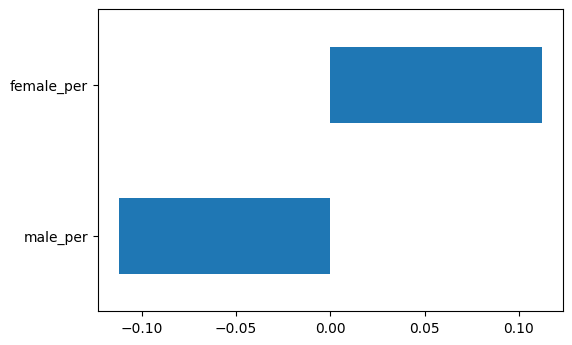

In [22]:
# bar plot betweeen male and female sat score correlations
genders = ['male_per', 'female_per']
correlations_genders = correlations.loc[genders]

correlations_genders.plot.barh()

Weak correlations for both male and females

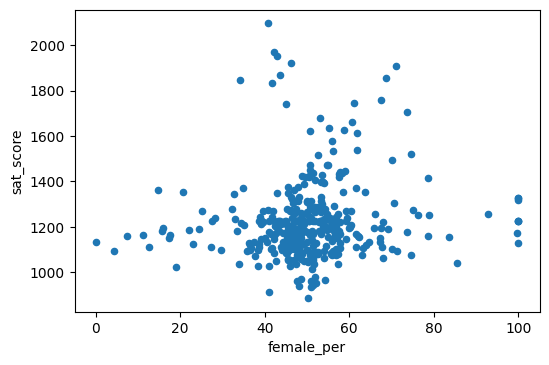

In [23]:
# schools with high sat scores and high female percentage
combined.plot.scatter('female_per', 'sat_score')

In [24]:
female_schools = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1600)]

# List of high percentage female and high scoring school names
female_schools['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
287                    BARD HIGH SCHOOL EARLY COLLEGE II
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Similarly, these schools all seem to be prestigous and rigorous schools intending to prepare students for college or even 'early college' schools.

## AP Scores vs SAT Scores

In [28]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined['ap_per']

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64

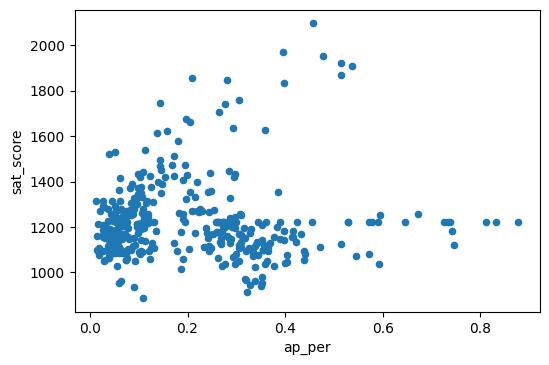

Correlation: 0.05717081390766969


In [32]:
combined.plot.scatter('ap_per', 'sat_score')
plt.show()
print("Correlation:", combined['ap_per'].corr(combined['sat_score']))

## Next Steps

To further analyze the data, here are some potential next steps:
- Determine whether there is a class size and SAT scores correlation
- Find which neighborhoods have the best schools
- investigate the differences between parent, teacher, and student survey responses.
- assign scores to schools based on sat_score and other attributes